# OCR Setup

In [ ]:
!sudo apt-get update -qq
!sudo apt-get install -qq unifont tesseract-ocr libtesseract-dev libleptonica-dev pkg-config
!pip install pillow tesserocr -q
# Arial Unicode font works best for OCR + Unicode support
!mkdir -p /usr/share/fonts/truetype/arialuni/
!curl -s https://raw.githubusercontent.com/kaienfr/Font/master/font/ARIALUNI.TTF --output /usr/share/fonts/truetype/arialuni/arialuni.ttf
!chmod 644 /usr/share/fonts/truetype/arialuni/arialuni.ttf
!fc-cache -f
!cp unifont.traineddata /usr/share/tesseract-ocr/4.00/tessdata/

In [ ]:
import tesserocr
from PIL import Image, ImageDraw, ImageFont, ImageFilter
import torchvision.transforms as transforms
import torch
import numpy as np
from PIL import Image
from math import ceil
from typing import List

# should be a multiple of 2
font_size = 32
# arialuni.ttf best for tesserocr, unifont.ttf best for unicode coverage
font_file = "unifont.ttf"

font = ImageFont.truetype(font_file, font_size)     
_d = ImageDraw.Draw(Image.new("1", (0, 0), 1))

def draw(text: str) -> Image:
  img = Image.new("1", _d.textsize(text, font=font), 1)
  d = ImageDraw.Draw(img)
  d.text((0, 0), text, font=font, fill=0)
  return img

def ocr(img: Image) -> str:
  # Tesseract works better if you fine-tune it on your font.
  # If you do this, specify the new model with `lang=`
  return tesserocr.image_to_text(img).rstrip('\n')

def draw_ocr(text: str) -> str:
  return ocr(draw(text))

# OCR Defence Experiment

In [ ]:
# Install dependencies
!pip install pyarrow
!pip install fairseq
!pip install sacremoses
!pip install fastBPE
!pip install subword_nmt
!pip install textdistance[extras]
!pip install scipy
!pip install requests
!pip install python-bidi
!pip install sacrebleu==1.5.1
!pip install textdistance[extras]
!pip install tqdm
!pip install hydra-core==1.0.7

In [ ]:
# Load pre-trained translation model
import torch
en2fr = torch.hub.load('pytorch/fairseq',
                       'transformer.wmt14.en-fr',
                       tokenizer='moses',
                       bpe='subword_nmt').cuda()

In [ ]:
from bidi.algorithm import get_display

# Unicode Bidi override characters
PDF = chr(0x202C)
LRE = chr(0x202A)
RLE = chr(0x202B)
LRO = chr(0x202D)
RLO = chr(0x202E)
PDI = chr(0x2069)
LRI = chr(0x2066)
RLI = chr(0x2067)
# Backspace character
BKSP = chr(0x8)

def bidi(text: str) -> str:
  """Applies Bidi algorithm."""
  text = get_display(text)
  for code in [PDF, LRE, RLE, LRO, RLO, PDI, LRI, RLI]:
    text = text.replace(code, '')
  return text

def backspace(text: str) -> str:
  """Applies backspace control characters."""
  while BKSP in text:
    i = text.index(BKSP)
    text = text[:i-1] + text[i+1:]
  return text

def render(text: str) -> str:
  return draw_ocr(bidi(backspace(text)))

In [5]:
import pickle

with open('../results/adversarial-examples.pkl', 'rb') as f:
  examples = pickle.load(f)

In [ ]:
from sacrebleu import corpus_bleu
from textdistance import levenshtein
from tqdm.auto import tqdm

defences = {}
for method in tqdm(['translation_invisibles', 'translation_homoglyphs', 'translation_reorderings', 'translation_deletions'], leave=True, desc="Method"):
  defences[method] = {}
  for budget, docs in tqdm(examples[method].items(), leave=False, desc="Budget"):
    defences[method][budget] = {}
    for docid, segs in tqdm(docs.items(), leave=False, desc="Doc"):
      defences[method][budget][docid] = {}
      for segid, seg in tqdm(segs.items(), desc="Seg", leave=False):
        rendered = render(seg['adv_example'])
        result = en2fr.translate(rendered)
        defences[method][budget][docid][segid] = {
              'defence_translation': result,
              'defence_ocr': rendered,
              'adv_example': seg['adv_example'],
              'adv_example_enc': seg['adv_example_enc'],
              'adv_translation': seg['adv_translation'],
              'input_translation_distance': levenshtein.distance(result, seg['input_translation']),
              'ref_translation_distance': levenshtein.distance(result, seg['ref_translation']),
              'input': seg['input'],
              'input_translation': seg['input_translation'],
              'ref_translation': seg['ref_translation'],
              'ref_bleu': corpus_bleu(seg['ref_translation'], result).score,
              'input_bleu': corpus_bleu(seg['input_translation'], result).score,
              'budget': budget
            }

import pickle

with open("../results/ocr-defense.pkl", "wb") as f:
  pickle.dump(defences, f)

In [1]:
# Once the experiment has been run once, the graph can be plotted with the pickle
import pickle
with open("../results/ocr-defense.pkl", "rb") as f:
  defences = pickle.load(f)

## Graphs

In [ ]:
!pip install matplotlib
!pip install seaborn

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [3]:
def budget_graph_data(exp: str, max_budget=None, levenshtein=False):
  count = []
  total = []
  budgets = []
  for budget, budgetexps in sorted(exp.items(), key=lambda x: int(x[0])):
    if not max_budget or int(budget) <= int(max_budget):
      count.append(0)
      total.append(0)
      budgets.append(int(budget))
      for docid, docexps in budgetexps.items():
        for segid, result in docexps.items():
          if levenshtein:
            count[-1] += result['ref_translation_distance']
          else:
            count[-1] += result['ref_bleu']
          total[-1] += 1
  return budgets, list(map(lambda x,y: x/y, count, total))

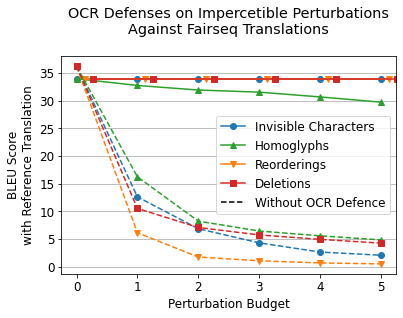

In [7]:
# BLEU Plot vs OCR
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import transforms



fig, ax = plt.subplots()

tr1 = transforms.offset_copy(ax.transData, fig=fig, x=8, y=0, units='points')
tr2 = transforms.offset_copy(ax.transData, fig=fig, x=16, y=0, units='points')



plt.rc('font', size=12) 

plt.plot(*budget_graph_data(defences['translation_invisibles']), linestyle='-', marker='o', color="tab:blue", label="Invisible Characters")
plt.plot(*budget_graph_data(defences['translation_homoglyphs']), linestyle='-', marker='^', color="tab:green", label="Homoglyphs")
plt.plot(*budget_graph_data(defences['translation_reorderings']), linestyle='-', marker='v', color="tab:orange", label="Reorderings", transform=tr1)
plt.plot(*budget_graph_data(defences['translation_deletions']), linestyle='-', marker='s', color="tab:red", label="Deletions", transform=tr2)
plt.plot(*budget_graph_data(examples['translation_invisibles']), linestyle='--', marker='o', color="tab:blue")
plt.plot(*budget_graph_data(examples['translation_homoglyphs']), linestyle='--', marker='^', color="tab:green")
plt.plot(*budget_graph_data(examples['translation_reorderings']), linestyle='--', marker='v', color="tab:orange")
plt.plot(*budget_graph_data(examples['translation_deletions']), linestyle='--', marker='s', color="tab:red")
plt.plot([],[], linestyle='--', color="black", label="Without OCR Defence")

plt.xlabel("Perturbation Budget")
plt.ylabel("BLEU Score\nwith Reference Translation")
plt.title("OCR Defenses on Impercetible Perturbations\nAgainst Fairseq Translations\n")
plt.xticks(range(6))
plt.legend()
plt.grid(axis='y')
plt.savefig("../results/figures/ocr_fairseq.pdf", bbox_inches='tight')
plt.show()